# CNN en MNIST — Análisis de Arquitecturas Convolucionales

**Autor:** Samuel Leonardo Albarracín Vergara  
**Curso:** AREP  
**Fecha:** 03/02/2026

---

En este notebook voy a comparar una red neuronal tradicional (fully connected) contra una CNN para clasificar dígitos de MNIST. La idea es entender qué ventaja real dan las convoluciones y por qué funcionan mejor para imágenes.

También hago un experimento variando el tamaño del kernel para ver cómo afecta el rendimiento.

# Parte 1: Exploración de Datos (EDA)

## 1.1 Carga del Dataset
Voy a usar MNIST que viene incluido en Keras. Es un dataset de dígitos manuscritos (0-9), con imágenes de 28×28 en escala de grises.

In [13]:
%pip install tensorflow matplotlib numpy pandas



                                              0.0/9.9 MB ? eta -:--:--
     -                                        0.4/9.9 MB 7.6 MB/s eta 0:00:02
     ----                                     1.0/9.9 MB 16.4 MB/s eta 0:00:01
     --------                                 2.1/9.9 MB 15.0 MB/s eta 0:00:01
     ------------                             3.1/9.9 MB 16.3 MB/s eta 0:00:01
     -----------------                        4.3/9.9 MB 18.1 MB/s eta 0:00:01
     ---------------------                    5.3/9.9 MB 18.8 MB/s eta 0:00:01
     ------------------------                 6.2/9.9 MB 19.6 MB/s eta 0:00:01
     ----------------------------             7.1/9.9 MB 18.2 MB/s eta 0:00:01
     -------------------------------          7.9/9.9 MB 18.7 MB/s eta 0:00:01
     -----------------------------------      8.8/9.9 MB 18.6 MB/s eta 0:00:01
     ---------------------------------------  9.7/9.9 MB 18.7 MB/s eta 0:00:01
     ---------------------------------------  9.9/9.9 MB 18.5


[notice] A new release of pip is available: 23.1.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:

from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

# Cargar datos
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"Tamaño de x_train: {x_train.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de x_test: {x_test.shape}")
print(f"Tamaño de y_test: {y_test.shape}")
print(f"\nRango de píxeles: [{x_train.min()}, {x_train.max()}]")

Tamaño de x_train: (60000, 28, 28)
Tamaño de y_train: (60000,)
Tamaño de x_test: (10000, 28, 28)
Tamaño de y_test: (10000,)

Rango de píxeles: [0, 255]


## 1.2 Análisis de Distribución de Clases

In [15]:
import pandas as pd

# Contar ejemplos por clase
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

# Crear tabla
dist_df = pd.DataFrame({
    'Dígito': unique_train,
    'Entrenamiento': counts_train,
    'Prueba': counts_test
})

print("Distribución de clases:")
print(dist_df)
print(f"\nTotal entrenamiento: {counts_train.sum()}")
print(f"Total prueba: {counts_test.sum()}")

Distribución de clases:
   Dígito  Entrenamiento  Prueba
0       0           5923     980
1       1           6742    1135
2       2           5958    1032
3       3           6131    1010
4       4           5842     982
5       5           5421     892
6       6           5918     958
7       7           6265    1028
8       8           5851     974
9       9           5949    1009

Total entrenamiento: 60000
Total prueba: 10000


Las clases están bastante balanceadas, más o menos 6000 muestras por dígito en entrenamiento. Esto es bueno porque no necesitamos preocuparnos por desbalance de clases ni usar técnicas como oversampling.

## 1.3 Visualización de Ejemplos
Veamos cómo se ven los dígitos. Muestro uno de cada clase para tener una idea de la variabilidad.

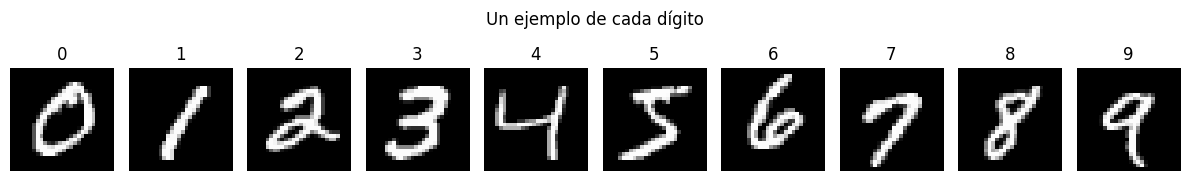

In [16]:
# Un ejemplo por clase
plt.figure(figsize=(12, 2))
for digit in range(10):
    idx = np.where(y_train == digit)[0][0]
    plt.subplot(1, 10, digit + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(f"{digit}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Un ejemplo de cada dígito', y=1.05)
plt.show()

## 1.4 Análisis de Píxeles y Preprocesamiento

Antes de normalizar, quiero ver cómo están distribuidos los valores de los píxeles.

Estadísticas de píxeles (valor original 0-255):
Min: 0, Max: 255
Media: 33.32
Desv. Est.: 78.57
Mediana: 0.00


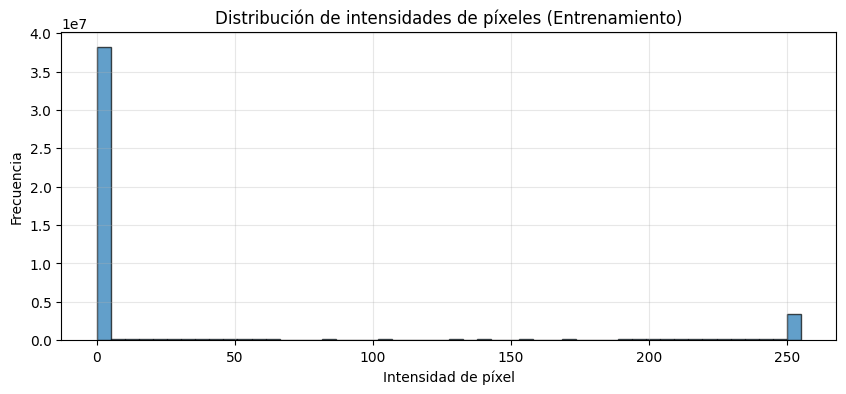

In [17]:
# Estadísticas de píxeles
print("Estadísticas de píxeles (valor original 0-255):")
print(f"Min: {x_train.min()}, Max: {x_train.max()}")
print(f"Media: {x_train.mean():.2f}")
print(f"Desv. Est.: {x_train.std():.2f}")
print(f"Mediana: {np.median(x_train):.2f}")

# Histograma de valores
plt.figure(figsize=(10, 4))
plt.hist(x_train.flatten(), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Intensidad de píxel')
plt.ylabel('Frecuencia')
plt.title('Distribución de intensidades de píxeles (Entrenamiento)')
plt.grid(alpha=0.3)
plt.show()

## 1.5 Normalización

Hay que normalizar los píxeles al rango [0, 1] dividiendo por 255. Esto ayuda bastante al entrenamiento porque los gradientes se mantienen en magnitudes razonables y Adam converge más rápido.

$$x_{norm} = \frac{x}{255}$$

In [18]:
# Normalizar
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

print("Después de normalización:")
print(f"Min: {x_train_norm.min()}, Max: {x_train_norm.max()}")
print(f"Media: {x_train_norm.mean():.4f}")
print(f"Desv. Est.: {x_train_norm.std():.4f}")

Después de normalización:
Min: 0.0, Max: 1.0
Media: 0.1307
Desv. Est.: 0.3081


## 1.6 Resumen del EDA

| Característica | Valor |
|---|---|
| Imágenes de entrenamiento | 60,000 |
| Imágenes de prueba | 10,000 |
| Dimensiones | 28 × 28 píxeles |
| Canales | 1 (escala de grises) |
| Clases | 10 (dígitos 0-9) |
| Distribución | Balanceada (~6000/clase) |
| Rango original | [0, 255] |
| Rango normalizado | [0, 1] |

MNIST es un buen dataset para probar CNNs porque los dígitos tienen patrones espaciales claros: bordes, curvas, intersecciones. Estos son exactamente el tipo de características que un kernel convolucional puede detectar. Además cabe fácilmente en memoria y entrena rápido.

# Parte 2: Modelo Baseline (Sin Convoluciones)

Primero necesito un punto de referencia. Voy a hacer un modelo simple con capas Dense (fully connected) para después poder comparar cuánto mejora la CNN.

## Arquitectura

Input (28x28) → Flatten (784) → Dense(128, ReLU) → Dense(10, Softmax)

Lo que hace Flatten es aplanar la imagen de 28×28 a un vector de 784. Esto significa que se pierde toda la información de qué píxeles son vecinos entre sí. La capa Dense(128) conecta cada uno de esos 784 valores con 128 neuronas, lo que da 784×128 = 100,352 pesos solo en esa capa.

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

# One-hot encoding de las etiquetas
y_train_oh = to_categorical(y_train, 10)
y_test_oh = to_categorical(y_test, 10)

# Construir el modelo baseline
baseline_model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

baseline_model.summary()

c:\Users\tolom\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

## 2.1 Compilación y Entrenamiento

Uso Adam como optimizador y categorical crossentropy como loss (ya que las etiquetas están en one-hot). Pongo `validation_split=0.1` para reservar un 10% de los datos de entrenamiento como validación y así poder ver si hay overfitting.

In [20]:
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_history = baseline_model.fit(
    x_train_norm, y_train_oh,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9203 - loss: 0.2803 - val_accuracy: 0.9623 - val_loss: 0.1276
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9641 - loss: 0.1220 - val_accuracy: 0.9740 - val_loss: 0.0937
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9749 - loss: 0.0829 - val_accuracy: 0.9738 - val_loss: 0.0858
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9813 - loss: 0.0615 - val_accuracy: 0.9737 - val_loss: 0.0832
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9855 - loss: 0.0472 - val_accuracy: 0.9767 - val_loss: 0.0787
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9892 - loss: 0.0361 - val_accuracy: 0.9783 - val_loss: 0.0774
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9908 - loss: 0.0294 - val_accuracy: 0.9793 - val_loss: 0.0766
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9929 - loss: 0.0227 - 

## 2.2 Curvas de Entrenamiento

Grafico el loss y accuracy durante el entrenamiento. Si el train sigue bajando pero el validation se estanca o sube, es señal de overfitting.

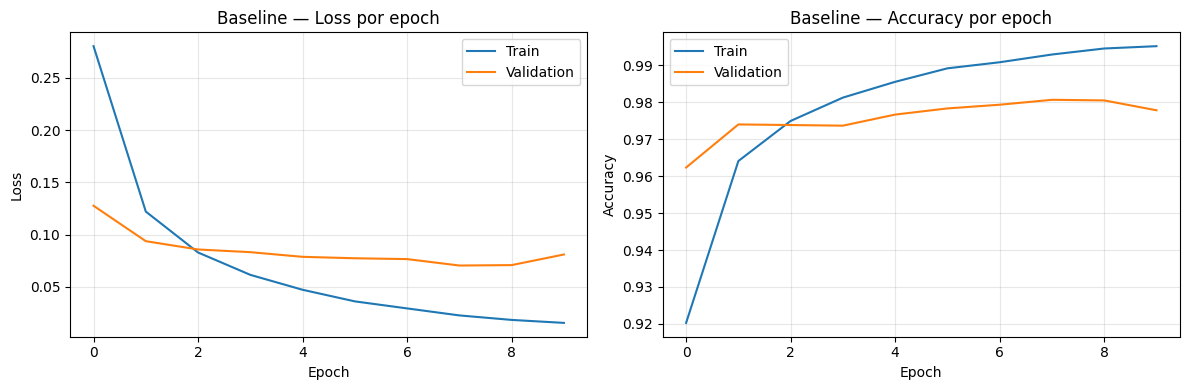

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(baseline_history.history['loss'], label='Train')
ax1.plot(baseline_history.history['val_loss'], label='Validation')
ax1.set_title('Baseline — Loss por epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy
ax2.plot(baseline_history.history['accuracy'], label='Train')
ax2.plot(baseline_history.history['val_accuracy'], label='Validation')
ax2.set_title('Baseline — Accuracy por epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 2.3 Evaluación en Test

In [22]:
baseline_loss, baseline_acc = baseline_model.evaluate(x_test_norm, y_test_oh, verbose=0)

print(f"Baseline — Test Loss:     {baseline_loss:.4f}")
print(f"Baseline — Test Accuracy: {baseline_acc:.4f}")
print(f"\nTotal de parámetros: {baseline_model.count_params():,}")

Baseline — Test Loss:     0.0906
Baseline — Test Accuracy: 0.9754

Total de parámetros: 101,770


## 2.4 Limitaciones del Baseline

Mirando los resultados, el modelo anda decente (~97% accuracy) pero tiene varios problemas de fondo:

1. **Pierde la estructura espacial:** Al hacer Flatten, el modelo no tiene forma de saber que el píxel (5,5) está al lado del (5,6). Trata la imagen como si fuera una lista de 784 números sueltos.

2. **Demasiados parámetros para lo que hace:** La primera capa Dense tiene más de 100k pesos porque conecta cada píxel con cada neurona. Muchos de esos píxeles son fondo negro que no aporta nada, pero el modelo igual dedica parámetros a ellos.

3. **No tiene invariancia a traslación:** Si un "3" aparece un poco corrido hacia la derecha, para el modelo es un patrón totalmente distinto. No puede "reusar" lo que aprendió de un "3" centrado.

Básicamente, el modelo funciona a pesar de ignorar que los datos son imágenes, no gracias a ello. Las convoluciones deberían resolver estos problemas.

# Parte 3: Diseño de la CNN

Ahora diseño una CNN para el mismo problema. La idea general es tener bloques de convolución + pooling que extraigan características espaciales, y después una capa Dense al final que clasifique.

```
Input(28x28x1) → Conv2D(32, 3x3) → MaxPool(2x2) → Conv2D(64, 3x3) → MaxPool(2x2) → Flatten → Dense(64) → Dense(10)
```

## ¿Por qué estas decisiones?

- **2 capas convolucionales:** La primera detecta cosas simples como bordes y esquinas. La segunda combina esos bordes en patrones más complejos (curvas, trazos completos). Para MNIST no creo que haga falta más profundidad, los dígitos no son tan complejos.

- **Kernel 3×3:** Es el más chico que tiene sentido (un vecindario de 3×3 píxeles). Para imágenes de 28×28, usar kernels muy grandes como 7×7 haría que el feature map se achique muy rápido. Además en la parte 4 voy a experimentar con otros tamaños para confirmar esto.

- **Filtros 32 → 64:** Voy duplicando los filtros a medida que el tamaño espacial se reduce. La primera capa necesita pocos filtros porque los patrones son simples; la segunda necesita más para representar combinaciones de esos patrones.

- **Padding valid (sin padding):** No agrego ceros alrededor de la imagen. Con 28×28 la reducción es manejable (28→26→13→11→5 después de las dos conv+pool).

- **Stride 1:** Dejo que el kernel se deslice de a 1 píxel. La reducción de tamaño la delego al pooling.

- **MaxPooling 2×2:** Reduce las dimensiones a la mitad y da algo de invariancia a pequeñas traslaciones. Uso Max en vez de Average porque me interesan las activaciones más fuertes (donde está el trazo del dígito).

- **ReLU:** Es la activación estándar para CNNs. Es simple (`max(0, x)`) y no tiene el problema de vanishing gradient que tienen sigmoid o tanh.

- **Dense(64):** Más chica que en el baseline (128) porque las capas conv ya procesaron las features. No necesito tantas neuronas para clasificar a partir de features ya extraídas.

## Flujo de dimensiones

Para verificar que todo cuadra, hago la cuenta de cómo cambia el tamaño del tensor:

| Capa | Output Shape | Parámetros |
|------|-------------|------------|
| Input | 28×28×1 | 0 |
| Conv2D(32, 3×3) | 26×26×32 | (3×3×1+1)×32 = 320 |
| MaxPool(2×2) | 13×13×32 | 0 |
| Conv2D(64, 3×3) | 11×11×64 | (3×3×32+1)×64 = 18,496 |
| MaxPool(2×2) | 5×5×64 | 0 |
| Flatten | 1600 | 0 |
| Dense(64) | 64 | 102,464 |
| Dense(10) | 10 | 650 |
| **Total** | | **~121,930** |

Interesante: la CNN tiene más parámetros que el baseline (~101k), pero la mayoría están en la capa Dense final, no en las convoluciones. Las capas conv solo tienen ~19k parámetros entre las dos, gracias a que comparten pesos (weight sharing).

## 3.1 Implementación del modelo CNN

In [23]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Reshape para Conv2D: agregar canal (28,28) -> (28,28,1)
x_train_cnn = x_train_norm.reshape(-1, 28, 28, 1)
x_test_cnn = x_test_norm.reshape(-1, 28, 28, 1)

# Construir la CNN
cnn_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

cnn_model.summary()

c:\Users\tolom\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Entrenamiento de la CNN

Uso exactamente los mismos hiperparámetros que en el baseline (Adam, crossentropy, 10 epochs, batch 32, validation 10%) para que la comparación sea justa. Lo único que cambió es la arquitectura.

In [24]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_history = cnn_model.fit(
    x_train_cnn, y_train_oh,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9527 - loss: 0.1549 - val_accuracy: 0.9822 - val_loss: 0.0589
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9847 - loss: 0.0501 - val_accuracy: 0.9882 - val_loss: 0.0401
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9889 - loss: 0.0347 - val_accuracy: 0.9900 - val_loss: 0.0372
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9914 - loss: 0.0263 - val_accuracy: 0.9898 - val_loss: 0.0347
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9939 - loss: 0.0196 - val_accuracy: 0.9892 - val_loss: 0.0419
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9950 - loss: 0.0150 - val_accuracy: 0.9893 - val_loss: 0.0459
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9963 - loss: 0.0113 - val_accuracy: 0.9898 - val_loss: 0.0371
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9965 - loss: 0

## 3.3 Comparación Baseline vs CNN

COMPARACIÓN BASELINE vs CNN
Métrica                     Baseline        CNN
--------------------------------------------------
Test Accuracy                 0.9754     0.9894
Test Loss                     0.0906     0.0416
Parámetros                   101,770    121,930
--------------------------------------------------
Mejora en accuracy             +1.40%


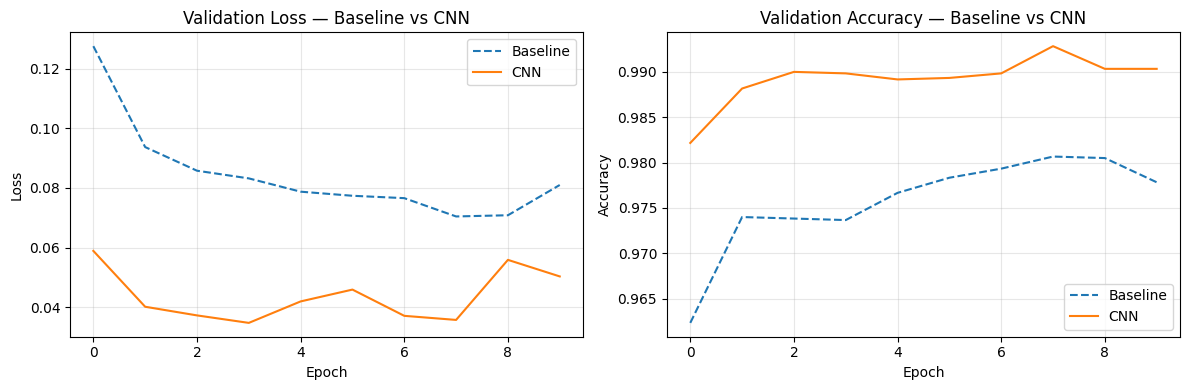

In [25]:
# Evaluación en test
cnn_loss, cnn_acc = cnn_model.evaluate(x_test_cnn, y_test_oh, verbose=0)

print("=" * 50)
print("COMPARACIÓN BASELINE vs CNN")
print("=" * 50)
print(f"{'Métrica':<25} {'Baseline':>10} {'CNN':>10}")
print("-" * 50)
print(f"{'Test Accuracy':<25} {baseline_acc:>10.4f} {cnn_acc:>10.4f}")
print(f"{'Test Loss':<25} {baseline_loss:>10.4f} {cnn_loss:>10.4f}")
print(f"{'Parámetros':<25} {baseline_model.count_params():>10,} {cnn_model.count_params():>10,}")
print("-" * 50)
print(f"{'Mejora en accuracy':<25} {(cnn_acc - baseline_acc)*100:>+10.2f}%")

# Gráfica comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(baseline_history.history['val_loss'], label='Baseline', linestyle='--')
ax1.plot(cnn_history.history['val_loss'], label='CNN')
ax1.set_title('Validation Loss — Baseline vs CNN')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(baseline_history.history['val_accuracy'], label='Baseline', linestyle='--')
ax2.plot(cnn_history.history['val_accuracy'], label='CNN')
ax2.set_title('Validation Accuracy — Baseline vs CNN')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Parte 4: Experimento Controlado — Efecto del Kernel Size

Quiero probar si mi elección de kernel 3×3 realmente es la mejor o si un kernel más grande funciona mejor. Voy a probar con 3×3, 5×5 y 7×7.

**Lo importante:** solo cambio el tamaño del kernel, todo lo demás queda exactamente igual. Si no, no sabría si la diferencia viene del kernel o de otra cosa.

**Lo que espero:** El kernel 3×3 debería andar bien porque las imágenes son chicas (28×28). Un kernel 7×7 probablemente sea demasiado grande — en la primera capa ya reduciría la imagen a 22×22, y después del segundo conv+pool quedaría muy poco.

## 4.1 Función para construir y entrenar

Hago una función que solo recibe el kernel_size como parámetro y construye/entrena todo. Así me aseguro de que no se me escape ninguna otra diferencia entre los modelos.

In [26]:
def build_and_train_cnn(kernel_size, x_train, y_train, x_test, y_test):
    """
    Construye y entrena una CNN variando únicamente el kernel size.
    Todos los demás hiperparámetros se mantienen fijos.
    """
    model = Sequential([
        Conv2D(32, kernel_size=(kernel_size, kernel_size), activation='relu',
               input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(kernel_size, kernel_size), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        epochs=10,
                        batch_size=32,
                        validation_split=0.1,
                        verbose=0)

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    return model, history, test_loss, test_acc

## 4.2 Ejecución de los experimentos

In [27]:
kernel_sizes = [3, 5, 7]
results = {}

for ks in kernel_sizes:
    print(f"\n{'='*50}")
    print(f"Entrenando CNN con kernel {ks}x{ks}...")
    print(f"{'='*50}")

    model, history, test_loss, test_acc = build_and_train_cnn(
        ks, x_train_cnn, y_train_oh, x_test_cnn, y_test_oh
    )

    results[ks] = {
        'model': model,
        'history': history,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'params': model.count_params()
    }

    print(f"Kernel {ks}x{ks} — Test Acc: {test_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Params: {model.count_params():,}")


Entrenando CNN con kernel 3x3...
Kernel 3x3 — Test Acc: 0.9908, Test Loss: 0.0336, Params: 121,930

Entrenando CNN con kernel 5x5...
Kernel 5x5 — Test Acc: 0.9917, Test Loss: 0.0388, Params: 118,346

Entrenando CNN con kernel 7x7...
Kernel 7x7 — Test Acc: 0.9860, Test Loss: 0.0598, Params: 119,114


## 4.3 Resultados cuantitativos

In [30]:
# Tabla resumen
print(f"RESULTADOS — Experimento de Kernel Size")
print(f"{'Kernel':<12} {'Test Acc':>10} {'Test Loss':>10} {'Parámetros':>12} {'Feature Map (capa 1)':>20}")

for ks in kernel_sizes:
    r = results[ks]
    fm_size = 28 - ks + 1  # output size de la primera conv (sin padding)
    print(f"{f'{ks}x{ks}':<12} {r['test_acc']:>10.4f} {r['test_loss']:>10.4f} "
          f"{r['params']:>12,} {f'{fm_size}x{fm_size}':>20}")

print(f"{'Baseline FC':<12} {baseline_acc:>10.4f} {baseline_loss:>10.4f} "
      f"{baseline_model.count_params():>12,} {'N/A':>20}")

RESULTADOS — Experimento de Kernel Size
Kernel         Test Acc  Test Loss   Parámetros Feature Map (capa 1)
3x3              0.9908     0.0336      121,930                26x26
5x5              0.9917     0.0388      118,346                24x24
7x7              0.9860     0.0598      119,114                22x22
Baseline FC      0.9754     0.0906      101,770                  N/A


## 4.4 Visualización comparativa

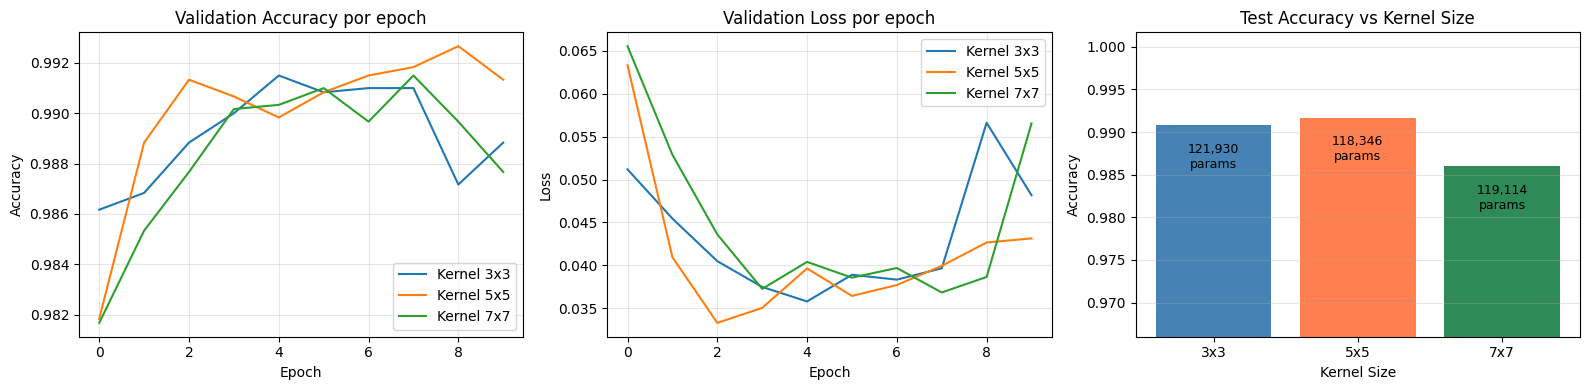

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1) Accuracy por epoch
for ks in kernel_sizes:
    axes[0].plot(results[ks]['history'].history['val_accuracy'], label=f'Kernel {ks}x{ks}')
axes[0].set_title('Validation Accuracy por epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2) Loss por epoch
for ks in kernel_sizes:
    axes[1].plot(results[ks]['history'].history['val_loss'], label=f'Kernel {ks}x{ks}')
axes[1].set_title('Validation Loss por epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3) Accuracy vs Parámetros (trade-off)
accs = [results[ks]['test_acc'] for ks in kernel_sizes]
params = [results[ks]['params'] for ks in kernel_sizes]
axes[2].bar([f'{ks}x{ks}' for ks in kernel_sizes], accs, color=['steelblue', 'coral', 'seagreen'])
for i, (a, p) in enumerate(zip(accs, params)):
    axes[2].text(i, a - 0.005, f'{p:,}\nparams', ha='center', fontsize=9)
axes[2].set_title('Test Accuracy vs Kernel Size')
axes[2].set_xlabel('Kernel Size')
axes[2].set_ylabel('Accuracy')
axes[2].set_ylim(min(accs) - 0.02, max(accs) + 0.01)
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 4.5 Análisis de resultados

En los resultados se observa que los tres tamaños de kernel superan al modelo baseline, lo cual confirma que introducir capas convolucionales mejora el desempeño para este tipo de imágenes.

El kernel **3×3** resulta el más eficiente. Tiene menos parámetros y mantiene feature maps más grandes, lo que deja más información disponible para las capas siguientes. El kernel **5×5** obtiene resultados similares, pero con un mayor costo en parámetros. En el caso del **7×7**, el desempeño es peor porque las dimensiones se reducen demasiado rápido: después de la primera convolución y el pooling, la imagen queda en 11×11, y tras la segunda convolión quedan muy pocos píxeles útiles.

### Trade-offs

Kernel  Pros  Contras 

3×3  Menos parámetros, mapas grandes  Captura poco contexto por capa 
5×5  Buen balance entre contexto y tamaño  Más parámetros, mapas más pequeños 
7×7  Captura mucho contexto de una vez  Reduce demasiado la resolución 

En resumen, para MNIST el kernel 3×3 es la mejor opción. Esto tiene sentido si se tiene en cuenta el tamaño de las imágenes: con solo 28×28 píxeles, usar kernels muy grandes hace que la información se pierda demasiado rápido. En imágenes mucho más grandes, como las de ImageNet, sí tiene sentido empezar con kernels grandes, pero ese no es el caso aquí.

## 5.1 ¿Por qué las capas convolucionales superaron al baseline?

La principal razón es que la CNN sí está pensada para trabajar con imágenes, mientras que el modelo baseline con capas Dense no.

Cuando se usa Flatten, la imagen deja de ser una matriz 2D y se convierte en un vector. En ese proceso se pierde por completo la información espacial: el modelo ya no sabe qué píxeles estaban juntos y cuáles estaban lejos. Para una capa Dense, todos los píxeles son solo números de entrada, sin ninguna relación entre ellos.

En cambio, las capas convolucionales trabajan mirando pequeñas regiones de la imagen, como ventanas de 3×3 píxeles. Esto tiene mucho más sentido, porque en las imágenes los patrones importantes (bordes, curvas, esquinas) aparecen entre píxeles cercanos, no entre píxeles que están en extremos opuestos de la imagen.  

Además, como el mismo kernel se aplica en toda la imagen, si la red aprende a detectar un cierto tipo de borde en una zona, automáticamente lo puede detectar en cualquier otra. En un modelo Dense, ese mismo patrón tendría que aprenderse varias veces dependiendo de la posición.

Por eso la CNN obtiene mejores resultados: no porque sea “más inteligente”, sino porque su forma de trabajar encaja mejor con la naturaleza de las imágenes.

---

## 5.2 ¿Qué sesgo inductivo introduce la convolución?

El sesgo inductivo se refiere a las suposiciones que el modelo hace antes de entrenar. En el caso de las convoluciones, estas suposiciones limitan lo que la red puede aprender, pero lo hacen de una forma útil para imágenes.

**Localidad:**  
Cada neurona convolucional solo ve una parte pequeña de la imagen, definida por el tamaño del kernel. Esto supone que la información importante está en patrones locales. En imágenes esto suele cumplirse, ya que los detalles relevantes no aparecen dispersos al azar.

**Equivariancia a la traslación:**  
Como los mismos pesos se usan en todas las posiciones, un patrón genera una activación similar sin importar dónde aparezca. Esto implica que una cifra sigue siendo la misma aunque esté ubicada en otra parte de la imagen, lo cual es razonable para este problema.

**Estructura jerárquica:**  
Al usar varias capas convolucionales una sobre otra, cada capa ve un área más grande de la imagen original. Las primeras capas suelen captar patrones simples como bordes, y las capas posteriores combinan esa información para representar formas más complejas. Esto asume que las imágenes se pueden entender de lo simple a lo complejo.

Estas suposiciones reducen el espacio de soluciones posibles, pero justamente por eso la red puede aprender más rápido y con menos datos cuando el problema cumple estas condiciones.

---

## 5.3 ¿Cuándo NO serviría usar convoluciones?

Las convoluciones dejan de ser útiles cuando los datos no cumplen las suposiciones anteriores.

**Datos tabulares:**  
En un conjunto de datos con columnas como edad, salario o ciudad, no existe una relación espacial entre columnas vecinas. El orden de las columnas es arbitrario, pero una convolución asumiría que las columnas cercanas están relacionadas, lo cual no tiene sentido en este tipo de datos.

**Texto con dependencias largas:**  
En tareas de lenguaje donde el significado depende de información muy lejana en la secuencia, una CNN tendría problemas para capturar ese contexto sin ser muy profunda. En estos casos, modelos como los Transformers funcionan mejor porque pueden atender a toda la secuencia al mismo tiempo.

**Grafos:**  
En problemas como redes sociales o moléculas, los datos no están organizados en una grilla regular. Las convoluciones estándar asumen una estructura fija en 2D, por lo que no se pueden aplicar directamente. Para estos casos se usan modelos diseñados específicamente para grafos.

En general, si los datos no tienen una estructura de grilla con patrones locales, usar convoluciones no suele aportar ventajas claras.
